In [1]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna 
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 42

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, RadioMaterial, Camera, LambertianPattern, DirectivePattern, BackscatteringPattern
from sionna.rt.utils import r_hat
from sionna.ofdm import ResourceGrid
from sionna.channel.utils import subcarrier_frequencies, cir_to_ofdm_channel
from sionna.constants import SPEED_OF_LIGHT
import time
from tensorflow.keras import Model
import sionna as sn

In [3]:
# ebno_db=10
# data_length=200
# coderate=data_length/(data_length+24)
# batch_size=50


# num_bits_per_symbol = 2

# rg = ResourceGrid(num_ofdm_symbols=1,
#                   fft_size=112,
#                   subcarrier_spacing=30e3)

# class my_crc_system(Model): # Inherits from Keras Model
#     def __init__(self,num_bits_per_symbol ,coderate ):
#         super().__init__() # Must call the Keras model initializer
#         self.num_bits_per_symbol=num_bits_per_symbol
#         self.coderate=coderate
#         frequencies = subcarrier_frequencies(rg.fft_size, rg.subcarrier_spacing)
#         self.binary_source = sn.utils.BinarySource()
#         self.encoder = sn.fec.crc.CRCEncoder(crc_degree="CRC24A")
#         self.decoder = sn.fec.crc.CRCDecoder(self.encoder)
#         self.constellation = sn.mapping.Constellation("qam", num_bits_per_symbol)
#         self.mapper = sn.mapping.Mapper(constellation=self.constellation)
#         self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)
#         self.awgn_channel = sn.channel.AWGN()
        


#     #@tf.function # activate graph execution to speed things up
#     def __call__(self, batch_size, ebno_db):
#         no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol=self.num_bits_per_symbol, coderate=self.coderate)
        
#         bits = self.binary_source([batch_size, data_length])
        
#         codewords = self.encoder(bits)
#         x = self.mapper(codewords)
#         y = self.awgn_channel([x, no])
#         llr = self.demapper([y, no])
        
#         bits_hat, bits_valid = self.decoder(llr)
#         hard_bits_hat = tf.cast(bits_hat > 0, tf.float32)
#         return bits, hard_bits_hat





In [4]:
# crc_system = my_crc_system(num_bits_per_symbol=num_bits_per_symbol,
#                                    coderate=coderate)

# ber_plots = sn.utils.PlotBER("AWGN channel")
# ber_plots.simulate(crc_system,
#                    ebno_dbs=np.linspace(-10, 10, 20),
#                    batch_size=batch_size,
#                    num_target_block_errors=100,
#                    legend="CRC24A",
#                    soft_estimates=False,
#                    max_mc_iter=15,
#                    show_fig=True,
#                    forward_keyboard_interrupt=False)

In [5]:
from tensorflow.keras import Model
ebno_db=10
data_length=200
coderate=data_length/(data_length+24)
batch_size=50


num_bits_per_symbol = 2


class my_ldpc_system(Model): # Inherits from Keras Model
    def __init__(self,num_bits_per_symbol ,coderate ):
        super().__init__() # Must call the Keras model initializer

        self.num_bits_per_symbol=num_bits_per_symbol
        self.coderate=coderate
        self.binary_source = sn.utils.BinarySource()
        self.encoder = sn.fec.ldpc.encoding.LDPC5GEncoder(data_length, data_length+24)
        self.decoder = sn.fec.ldpc.decoding.LDPC5GDecoder(encoder=self.encoder, num_iter=20, return_infobits=True)
        self.constellation = sn.mapping.Constellation("qam", num_bits_per_symbol)
        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)
        self.awgn_channel = sn.channel.AWGN()
        


    #@tf.function # activate graph execution to speed things up
    def __call__(self, batch_size, ebno_db):
        no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol=self.num_bits_per_symbol, coderate=self.coderate)
        bits = self.binary_source([batch_size, 1, 1,data_length])
        codewords = self.encoder(bits)
        x = self.mapper(codewords)
        y = self.awgn_channel([x, no])
        llr = self.demapper([y, no])
        bits_hat= self.decoder(llr)
        return bits, bits_hat





In [6]:
from tensorflow.keras import Model
ebno_db=10
data_length=200
coderate=data_length/(data_length+24)
batch_size=50


num_bits_per_symbol = 2


class my_polar_system(Model): # Inherits from Keras Model
    def __init__(self,num_bits_per_symbol ,coderate ):
        super().__init__() # Must call the Keras model initializer

        self.num_bits_per_symbol=num_bits_per_symbol
        self.coderate=coderate
        self.binary_source = sn.utils.BinarySource()
        self.encoder = sn.fec.polar.encoding.Polar5GEncoder(data_length, data_length+24)
        self.decoder = sn.fec.polar.decoding.Polar5GDecoder(enc_polar=self.encoder, num_iter=20)
        self.constellation = sn.mapping.Constellation("qam", num_bits_per_symbol)
        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)
        self.awgn_channel = sn.channel.AWGN()
        


    #@tf.function # activate graph execution to speed things up
    def __call__(self, batch_size, ebno_db):
        no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol=self.num_bits_per_symbol, coderate=self.coderate)
        bits = self.binary_source([batch_size, 1, 1,data_length])
        codewords = self.encoder(bits)
        x = self.mapper(codewords)
        y = self.awgn_channel([x, no])
        llr = self.demapper([y, no])
        bits_hat= self.decoder(llr)
        return bits, bits_hat





EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 3.8190e-01 | 1.0000e+00 |        7638 |       20000 |          100 |         100 |         2.3 |reached target block errors
   -8.947 | 3.6715e-01 | 1.0000e+00 |        7343 |       20000 |          100 |         100 |         2.5 |reached target block errors
   -7.895 | 3.5255e-01 | 1.0000e+00 |        7051 |       20000 |          100 |         100 |         2.3 |reached target block errors
   -6.842 | 3.2995e-01 | 1.0000e+00 |        6599 |       20000 |          100 |         100 |         1.8 |reached target block errors
   -5.789 | 3.0815e-01 | 1.0000e+00 |        6163 |       20000 |          100 |         100 |         2.2 |reached target block errors
   -4.737 | 2.9100e-01 | 1.0000e+00 |        5820 |       20000 |

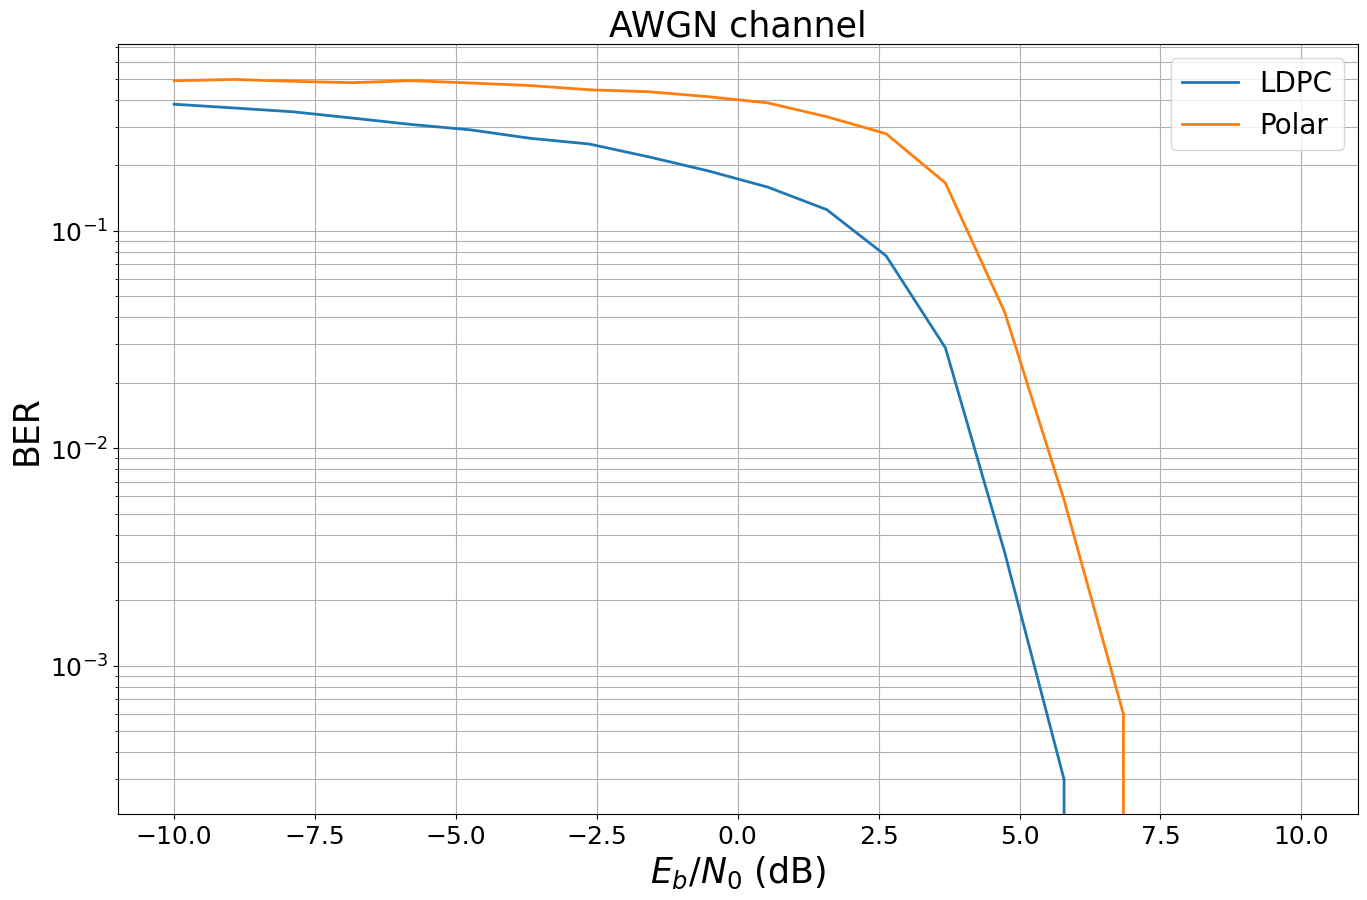

In [8]:
ebno_db=20
data_length=200
coderate=data_length/(data_length+24)
batch_size=50


# crc_system = my_crc_system(num_bits_per_symbol=num_bits_per_symbol,
#                                    coderate=coderate)
ldpc_system = my_ldpc_system(num_bits_per_symbol=num_bits_per_symbol,
                                   coderate=coderate)
polar_system = my_polar_system(num_bits_per_symbol=num_bits_per_symbol,
                                   coderate=coderate)

ber_plots = sn.utils.PlotBER("AWGN channel")
# ber_plots.simulate(crc_system,
#                    ebno_dbs=np.linspace(-10, 10, 20),
#                    batch_size=batch_size,
#                    num_target_block_errors=100,
#                    legend="CRC24A",
#                    soft_estimates=False,
#                    max_mc_iter=10,
#                    show_fig=True,
#                    forward_keyboard_interrupt=False);


ber_plots.simulate(ldpc_system,
                   ebno_dbs=np.linspace(-10, 10, 20),
                   batch_size=batch_size,
                   num_target_block_errors=100,
                   legend="LDPC",
                   soft_estimates=False,
                   max_mc_iter=10,
                   show_fig=False,
                   forward_keyboard_interrupt=False);



ber_plots.simulate(polar_system,
                   ebno_dbs=np.linspace(-10, 10, 20),
                   batch_size=batch_size,
                   num_target_block_errors=100,
                   legend="Polar",
                   soft_estimates=False,
                   max_mc_iter=15,
                   show_fig=True,
                   forward_keyboard_interrupt=False);

